In [1]:

import cv2
import numpy as np
import os
from utils import *

import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline



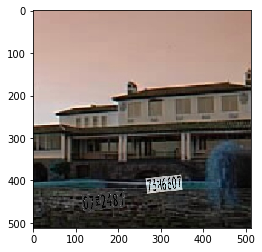

In [2]:
img = read_img('./gen-data/images/00000002.png', imshow=False)
plt.imshow(img)

### Boundbox Anchor 

-------------

- Plate image gen => original size : (184,825) 
- X rand size : 0.14 ~ 0.20 (26 ~ 37 )
- Y rand size : 0.14 ~ 0.28 ( 115 ~ 231 ) 

- YOLO grid pixels : 32 x 32 
- Anchor Size : [0.815, 3.59 , 0.48, 2.52, 1.156, 7.018, 1.623, 6.812 ] 

In [3]:
MODEL_NAME_ = 'yolo-test-v002'
NGPU = 4

In [4]:

#LABELS = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
LABELS = ['normal', 'taxi', 'truck']

IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45
ANCHORS          = [2.22, 1.2, 1.6, 0.8, 3.59, 0.815, 4.01, 2.2, 5.2, 3.1 ]
#ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
#ANCHORS          = [0.815, 3.59 , 0.48, 2.52, 1.156, 7.018, 1.623, 6.812, 2.01, 8.065 ]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 128
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}

wt_path = './model/yolov2.weights'
IMG_DIR = './gen-data/images/'
MASK_DIR = './gen-data/mask/'
LABEL_DIR = './gen-data/labels/'

In [14]:
import copy
from keras.utils import Sequence
import imgaug as ia
from imgaug import augmenters as iaa
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, c = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.c     = c
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

def normalize(image):
    return image / 255.

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3    
        
class BatchGenerator(Sequence):
    def __init__(self, images, 
                       config, 
                       shuffle=True, 
                       jitter=True, 
                       norm=None):
        self.generator = None

        self.images = images
        self.config = config

        self.shuffle = shuffle
        self.jitter  = jitter
        self.norm    = norm

        self.anchors = [BoundBox(0, 0, config['ANCHORS'][2*i], config['ANCHORS'][2*i+1]) for i in range(int(len(config['ANCHORS'])//2))]

        ### augmentors by https://github.com/aleju/imgaug
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)

        # Define our sequence of augmentation steps that will be applied to every image
        # All augmenters with per_channel=0.5 will sample one value _per image_
        # in 50% of all cases. In all other cases they will sample new values
        # _per channel_.
        
#        print ('__init__')


    def __len__(self):
#        print ('__len__')
        return int(np.ceil(float(len(self.images))/self.config['BATCH_SIZE']))   
    

    def num_classes(self):
#        print ('num_classes')
        return len(self.config['LABELS'])

    def size(self):
#        print ('size')
        return len(self.images)    

    def load_annotation(self, i):
#        print ('load_annotation')
        annots = []

        for obj in self.images[i]['object']:
            annot = [obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax'], self.config['LABELS'].index(obj['name'])]
            annots += [annot]

        if len(annots) == 0: annots = [[]]

        return np.array(annots)

    def load_image(self, i):
#        print ('load_image')
        return cv2.imread(self.images[i]['filename'])

    def __getitem__(self, idx):
#        print ('__getitem__')
        l_bound = idx*self.config['BATCH_SIZE']
        r_bound = (idx+1)*self.config['BATCH_SIZE']

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config['BATCH_SIZE']

        instance_count = 0

        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], self.config['IMAGE_W'], 3))                         # input images
        b_batch = np.zeros((r_bound - l_bound, 1     , 1     , 1    ,  self.config['TRUE_BOX_BUFFER'], 4))   # list of self.config['TRUE_self.config['BOX']_BUFFER'] GT boxes
        y_batch = np.zeros((r_bound - l_bound, self.config['GRID_H'],  self.config['GRID_W'], self.config['BOX'], 4+1+len(self.config['LABELS'])))                # desired network output

        for train_instance in self.images[l_bound:r_bound]:
            # augment input image and fix object's position and size
            img, all_objs = self.aug_image(train_instance, jitter=self.jitter)
            
            # construct output from object's x, y, w, h
            true_box_index = 0
            
            ori_img_w = 512
            ori_img_h = 512
            
            for obj in all_objs:
                
                
                
                obj['xmax'] = obj['xmax'] * (self.config['IMAGE_W']/ori_img_w)
                obj['xmin'] = obj['xmin'] * (self.config['IMAGE_W']/ori_img_w)
                obj['ymax'] = obj['ymax'] * (self.config['IMAGE_H']/ori_img_h)
                obj['ymin'] = obj['ymin'] * (self.config['IMAGE_H']/ori_img_h)
                
                if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
                    center_x = .5*(obj['xmin'] + obj['xmax'])
                    center_x = center_x / (float(self.config['IMAGE_W']) / self.config['GRID_W'])
                    center_y = .5*(obj['ymin'] + obj['ymax'])
                    center_y = center_y / (float(self.config['IMAGE_H']) / self.config['GRID_H'])

                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                        obj_indx  = self.config['LABELS'].index(obj['name'])
                        
                        center_w = (obj['xmax'] - obj['xmin']) / (float(self.config['IMAGE_W']) / self.config['GRID_W']) # unit: grid cell
                        center_h = (obj['ymax'] - obj['ymin']) / (float(self.config['IMAGE_H']) / self.config['GRID_H']) # unit: grid cell
                        
                        box = [center_x, center_y, center_w, center_h]

                        # find the anchor that best predicts this box
                        best_anchor = -1
                        max_iou     = -1
                        
                        shifted_box = BoundBox(0, 
                                               0,
                                               center_w,                                                
                                               center_h)
                        
                        for i in range(len(self.anchors)):
                            anchor = self.anchors[i]
                            iou    = bbox_iou(shifted_box, anchor)
                            
                            if max_iou < iou:
                                best_anchor = i
                                max_iou     = iou
                                
                        # assign ground truth x, y, w, h, confidence and class probs to y_batch
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 4  ] = 1.
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 5+obj_indx] = 1
                        
                        # assign the true box to b_batch
                        b_batch[instance_count, 0, 0, 0, true_box_index] = box
                        
                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
                            
            # assign input image to x_batch
            if self.norm != None: 
                x_batch[instance_count] = self.norm(img)
            else:
                # plot image and bounding boxes for sanity check
                for obj in all_objs:
                    if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin']:
                        cv2.rectangle(img[:,:,::-1], (obj['xmin'],obj['ymin']), (obj['xmax'],obj['ymax']), (255,0,0), 3)
                        cv2.putText(img[:,:,::-1], obj['name'], 
                                    (obj['xmin']+2, obj['ymin']+12), 
                                    0, 1.2e-3 * img.shape[0], 
                                    (0,255,0), 2)
                        
                x_batch[instance_count] = img

            # increase instance counter in current batch
            instance_count += 1  

#        print(' new batch created', idx)
        
        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
#        print ('on_epoch_end')
        if self.shuffle: np.random.shuffle(self.images)
            
    def aug_image(self, train_instance, jitter):
#        print ('aug_image')
        image_name = train_instance['filename']
        image = cv2.imread(image_name)
        image = cv2.resize(image, (IMAGE_H, IMAGE_W))
        

        if image is None: print('Cannot find ', image_name)

        h, w, c = image.shape
        all_objs = copy.deepcopy(train_instance['object'])
                
        return image, all_objs

class WeightReader:
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        self.offset = 4
        
def space_to_depth_x2(x):
    import tensorflow as tf
    return tf.space_to_depth(x, block_size=2)

In [15]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np
import pickle
import os, cv2
from keras.utils.training_utils import multi_gpu_model

In [16]:
K.clear_session()
print ('Session Reseted')
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))
    
def make_model():

    #with tf.device("/gpu:0"):

    # Layer 1
    x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
    x = BatchNormalization(name='norm_1')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 2
    x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
    x = BatchNormalization(name='norm_2')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 3
    x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
    x = BatchNormalization(name='norm_3')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 4
    x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
    x = BatchNormalization(name='norm_4')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 5
    x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
    x = BatchNormalization(name='norm_5')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 6
    x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
    x = BatchNormalization(name='norm_6')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 7
    x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
    x = BatchNormalization(name='norm_7')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 8
    x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
    x = BatchNormalization(name='norm_8')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 9
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
    x = BatchNormalization(name='norm_9')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 10
    x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
    x = BatchNormalization(name='norm_10')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 11
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
    x = BatchNormalization(name='norm_11')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 12
    x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
    x = BatchNormalization(name='norm_12')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 13
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
    x = BatchNormalization(name='norm_13')(x)
    x = LeakyReLU(alpha=0.1)(x)

    skip_connection = x

    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 14
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
    x = BatchNormalization(name='norm_14')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 15
    x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
    x = BatchNormalization(name='norm_15')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 16
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
    x = BatchNormalization(name='norm_16')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 17
    x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
    x = BatchNormalization(name='norm_17')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 18
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
    x = BatchNormalization(name='norm_18')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 19
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
    x = BatchNormalization(name='norm_19')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 20
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
    x = BatchNormalization(name='norm_20')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 21
    skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
    skip_connection = BatchNormalization(name='norm_21')(skip_connection)
    skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
    skip_connection = Lambda(space_to_depth_x2)(skip_connection)

    x = concatenate([skip_connection, x])

    # Layer 22
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
    x = BatchNormalization(name='norm_22')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 23
    x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

    # small hack to allow true_boxes to be registered when Keras build the model 
    # for more information: https://github.com/fchollet/keras/issues/2790
    output = Lambda(lambda args: args[0])([output, true_boxes])
    
    return Model([input_image, true_boxes], output)

b_model = make_model()
model = multi_gpu_model(b_model, gpus=NGPU)
print (MODEL_NAME_, 'Model Created')
print (b_model.summary())

Session Reseted
yolo-test-v002 Model Created
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 416, 416, 32) 0           norm_1[0][0]                     
________________________________________________________________

In [17]:
weight_reader = WeightReader(wt_path)
weight_reader.reset()
nb_conv = 23

for i in range(1, nb_conv+1):
    conv_layer = b_model.get_layer('conv_' + str(i))
    
    if i < nb_conv:
        norm_layer = b_model.get_layer('norm_' + str(i))
        
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])
        
layer   = b_model.layers[-4] # the last convolutional layer
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])

In [18]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss

In [19]:
def make_annotation(file_name):
    IMG_WIDTH, IMG_HEIGHT = 512 , 512
    obj, code, coord, m = open_label_file (file_name)
    rtn_dic = {}
    rtn_dic['filename'] = os.path.join(IMG_DIR, file_name[-12:-4]+'.png')
    rtn_dic['height'] = IMG_HEIGHT
    rtn_dic['width'] = IMG_WIDTH
    rtn_dic['object'] = []
    for item, m_coord, text in zip(obj, m, code):
        affine_coord = get_affine_coord(m_coord, item)
        x_max, x_min, y_max, y_min = affine_coord
        c0, tx1, tx2, tx3 = text
        tmp = {}
        tmp['name'] = LABELS[c0]
        tmp['xmax'] = x_max
        tmp['xmin'] = x_min
        tmp['ymax'] = y_max
        tmp['ymin'] = y_min
        tmp['tx0'] = 0
        tmp['tx1'] = tx1
        tmp['tx2'] = tx2
        tmp['tx3'] = tx3
        rtn_dic['object'].append(tmp)
    
    return rtn_dic

In [20]:

def make_data_dic(valid_ratio = 0.8):
    
    img_file_list = os.listdir(os.path.join(IMG_DIR))
    
    data = []
    for file in img_file_list:
        file_name = os.path.join(LABEL_DIR, file[:8]+'.txt')
        
        rtn_dic = make_annotation(file_name)
        if len(rtn_dic['object']) > 0:
            data.append(rtn_dic)
        
    train_size = int(len(data)*valid_ratio)
    return data[:train_size], data[train_size:]

train_imgs, valid_imgs = make_data_dic()
print (len(train_imgs), len(valid_imgs))

train_batch = BatchGenerator(train_imgs, generator_config, norm=normalize)
valid_batch = BatchGenerator(valid_imgs, generator_config, norm=normalize)

39959 9990


In [21]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=10, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('weights_coco.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [44]:
tb_counter  = len([log for log in os.listdir(os.path.expanduser('./log/')) if 'coco_' in log]) + 1
tensorboard = TensorBoard(log_dir=os.path.expanduser('./log/') + 'yolo2' + '_' + str(tb_counter), 
                          histogram_freq=0, 
                          write_graph=True, 
                          write_images=False)

optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
model.compile(loss=custom_loss, optimizer=optimizer)



model.fit_generator(generator        = train_batch, 
                steps_per_epoch  = len(train_batch), 
                epochs           = 1, 
                verbose          = 1,
                validation_data  = valid_batch,
                validation_steps = len(valid_batch),
                callbacks        = [early_stop, tensorboard], #checkpoint, tensorboard], 
                max_queue_size   = 3)

Epoch 1/1
313/313 [==============================] - 862s 3s/step - loss: 0.0034 - val_loss: 0.0025


In [23]:
save_model_name = './model/'+MODEL_NAME_+'.h5'
b_model.save(save_model_name)
print ('Model Saved', save_model_name)



Model Saved ./model/yolo-test-v002.h5


In [ ]:
#from keras.models import load_model
#loaded_model = load_model('./model/yolo-test-v002.h5')
#loaded_model.summary()


In [24]:
def decode_netout(netout, anchors, nb_class, obj_threshold=0.3, nms_threshold=0.3):
    grid_h, grid_w, nb_box = netout.shape[:3]

    boxes = []
    
    # decode the output by the network
    netout[..., 4]  = _sigmoid(netout[..., 4])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_threshold
    
    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(nb_box):
                # from 4th element onwards are confidence and class classes
                classes = netout[row,col,b,5:]
                
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout[row,col,b,:4]

                    x = (col + _sigmoid(x)) / grid_w # center position, unit: image width
                    y = (row + _sigmoid(y)) / grid_h # center position, unit: image height
                    w = anchors[2 * b + 0] * np.exp(w) / grid_w # unit: image width
                    h = anchors[2 * b + 1] * np.exp(h) / grid_h # unit: image height
                    confidence = netout[row,col,b,4]
                    
                    box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    
                    boxes.append(box)

    # suppress non-maximal boxes
    for c in range(nb_class):
        sorted_indices = list(reversed(np.argsort([box.classes[c] for box in boxes])))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            
            if boxes[index_i].classes[c] == 0: 
                continue
            else:
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                    
                    if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
                        boxes[index_j].classes[c] = 0
                        
    # remove the boxes which are less likely than a obj_threshold
    boxes = [box for box in boxes if box.get_score() > obj_threshold]
    
    return boxes    

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _softmax(x, axis=-1, t=-100.):
    x = x - np.max(x)
    
    if np.min(x) < t:
        x = x/np.min(x)*t
        
    e_x = np.exp(x)
    
    return e_x / e_x.sum(axis, keepdims=True)

def draw_boxes(image, boxes, labels):
    image_h, image_w, _ = image.shape

    for box in boxes:
        xmin = int(box.xmin*image_w)
        ymin = int(box.ymin*image_h)
        xmax = int(box.xmax*image_w)
        ymax = int(box.ymax*image_h)

        cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,255,0), 3)
        cv2.putText(image, 
                    labels[box.get_label()] + ' ' + str(box.get_score()), 
                    (xmin, ymin - 13), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    1e-3 * image_h, 
                    (0,255,0), 2)
        
    return image          

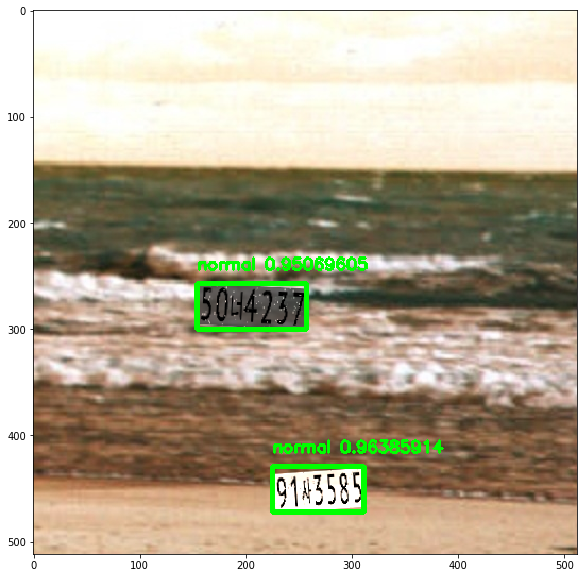

In [40]:


#image = read_img('./test-image/0001.jpeg', imshow=False)
image = cv2.imread("./gen-data/images/{:08d}.png".format(np.random.randint(0, 1100)))#'./gen-data/images/00000014.png')
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (416, 416))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

## Test using real world example (Can't detect small Plate) => Using Small Anchor 

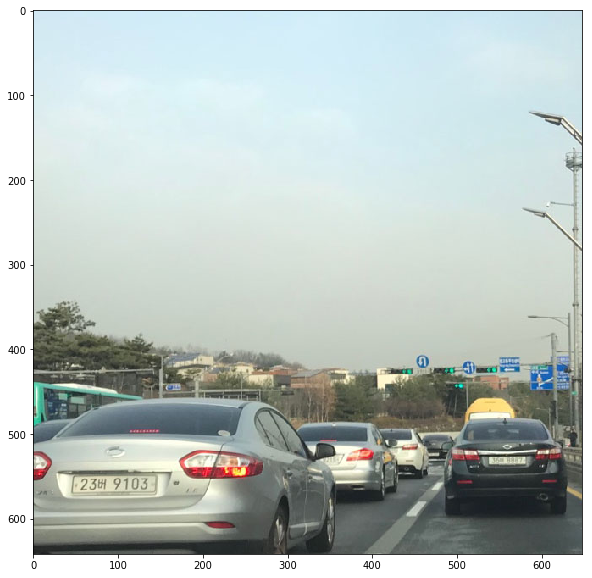

In [53]:


#image = read_img('./test-image/0001.jpeg', imshow=False)
image = cv2.imread('./test-image/0001.jpeg')
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (416, 416))
input_image = input_image / 255.
#input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

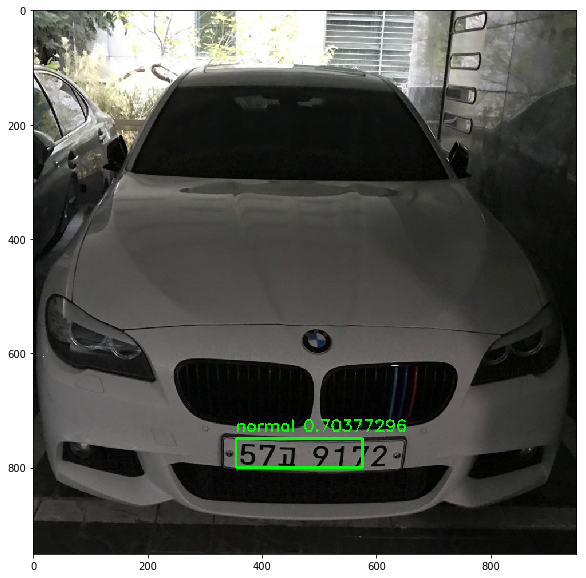

In [54]:


#image = read_img('./test-image/0001.jpeg', imshow=False)
image = cv2.imread('./test-image/0004.jpeg')
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (416, 416))
input_image = input_image / 255.
#input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

## Test using real world example (H-square)

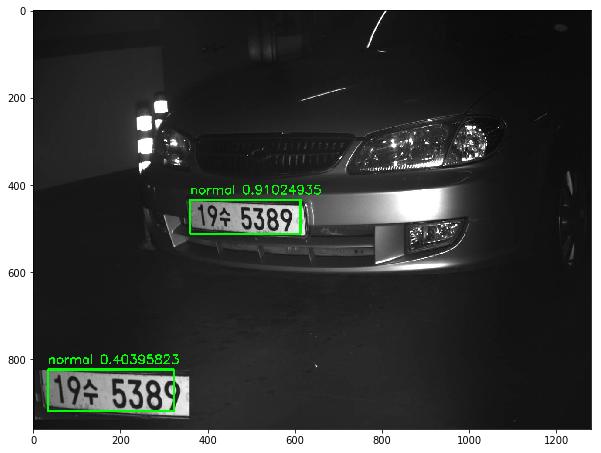

In [46]:



#image = read_img('./test-image/0001.jpeg', imshow=False)
image = cv2.imread("./original-image/001_H스퀘어N동_입차_20180705134715_19수5389.jpg")
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (416, 416))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()


## Load Saved Model and Testing 

In [47]:
from keras.models import load_model
loaded_model = load_model('./model/yolo-test-v002.h5')
loaded_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 416, 416, 32) 0           norm_1[0][0]                     
__________________________________________________________________________________________________
max_poolin

/usr/local/lib/python3.5/dist-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


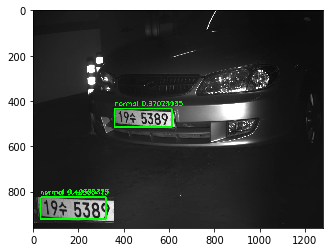

In [48]:

netout = loaded_model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()
